In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Data Loading and Initial Exploration

In this step, we load the dataset and take a first look at the structure of the data.


In [2]:
# Import libraries
import pandas as pd
import numpy as np

# Load the dataset
file_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
df = pd.read_csv(file_path)

# Display the first 5 rows
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Missing Value Analysis

In this step, we analyze missing values in the dataset to identify incomplete features.


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = 100 * missing_values / len(df)

# Combine into a DataFrame
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage (%)': missing_percentage})

# Sort descending by percentage
missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Percentage (%)', ascending=False)

# Display
missing_data


,Missing Values,Missing Percentage (%)
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


## Missing Value Handling

In this step, we handle missing values by dropping highly incomplete columns and imputing remaining missing values.


In [4]:
# Drop columns with more than 50% missing values
high_missing_cols = missing_data[missing_data['Missing Percentage (%)'] > 50].index
df.drop(columns=high_missing_cols, inplace=True)

# Fill numerical columns with median
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check again if any missing values remain
df.isnull().sum().sum()


/tmp/ipykernel_13/881003817.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_13/881003817.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

0

## Outlier Analysis (IQR Method)


In [5]:
# Select numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Detect outliers using IQR method
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


Id: 0 outliers
MSSubClass: 103 outliers
LotFrontage: 106 outliers
LotArea: 69 outliers
OverallQual: 2 outliers
OverallCond: 125 outliers
YearBuilt: 7 outliers
YearRemodAdd: 0 outliers
MasVnrArea: 98 outliers
BsmtFinSF1: 7 outliers
BsmtFinSF2: 167 outliers
BsmtUnfSF: 29 outliers
TotalBsmtSF: 61 outliers
1stFlrSF: 20 outliers
2ndFlrSF: 2 outliers
LowQualFinSF: 26 outliers
GrLivArea: 31 outliers
BsmtFullBath: 1 outliers
BsmtHalfBath: 82 outliers
FullBath: 0 outliers
HalfBath: 0 outliers
BedroomAbvGr: 35 outliers
KitchenAbvGr: 68 outliers
TotRmsAbvGrd: 30 outliers
Fireplaces: 5 outliers
GarageYrBlt: 1 outliers
GarageCars: 5 outliers
GarageArea: 21 outliers
WoodDeckSF: 32 outliers
OpenPorchSF: 77 outliers
EnclosedPorch: 208 outliers
3SsnPorch: 24 outliers
ScreenPorch: 116 outliers
PoolArea: 7 outliers
MiscVal: 52 outliers
MoSold: 0 outliers
YrSold: 0 outliers
SalePrice: 61 outliers


## Outlier Handling and Log Transformation

In this step, we apply log transformation to selected numerical features that contain outliers in order to reduce their impact and normalize the distribution. This helps to improve the model performance by stabilizing variance and making patterns more linear.


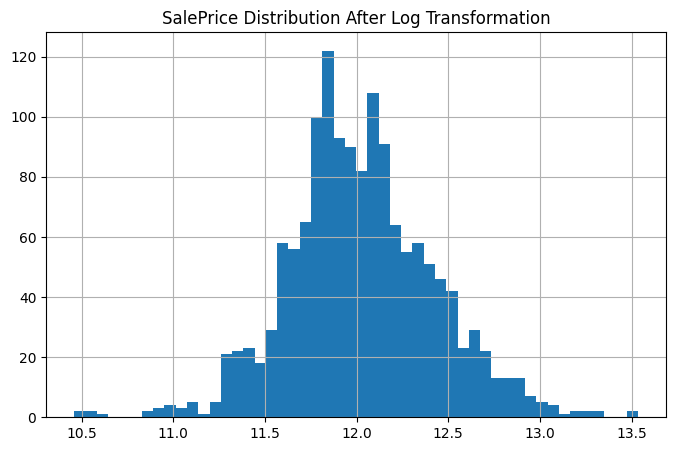

In [6]:
# Import library
import matplotlib.pyplot as plt
import numpy as np

# Apply log transformation to skewed numerical features

# List of selected numerical features (yüksek outlier'lara sahip olanlar)
log_features = ['SalePrice', 'LotArea', 'GrLivArea', 'MasVnrArea', 'TotalBsmtSF', 
                'BsmtFinSF1', '1stFlrSF', 'GarageArea', 'WoodDeckSF']

# Apply log1p (log(1+x)) transformation to avoid log(0) errors
for feature in log_features:
    df[feature] = np.log1p(df[feature])

# Kontrol için histograma bakalım (örnek: SalePrice)
plt.figure(figsize=(8,5))
df['SalePrice'].hist(bins=50)
plt.title("SalePrice Distribution After Log Transformation")
plt.show()


## Correlation Analysis and Feature Selection

In this step, we analyze correlations between numerical features to identify highly correlated variables, and select important features for the model.


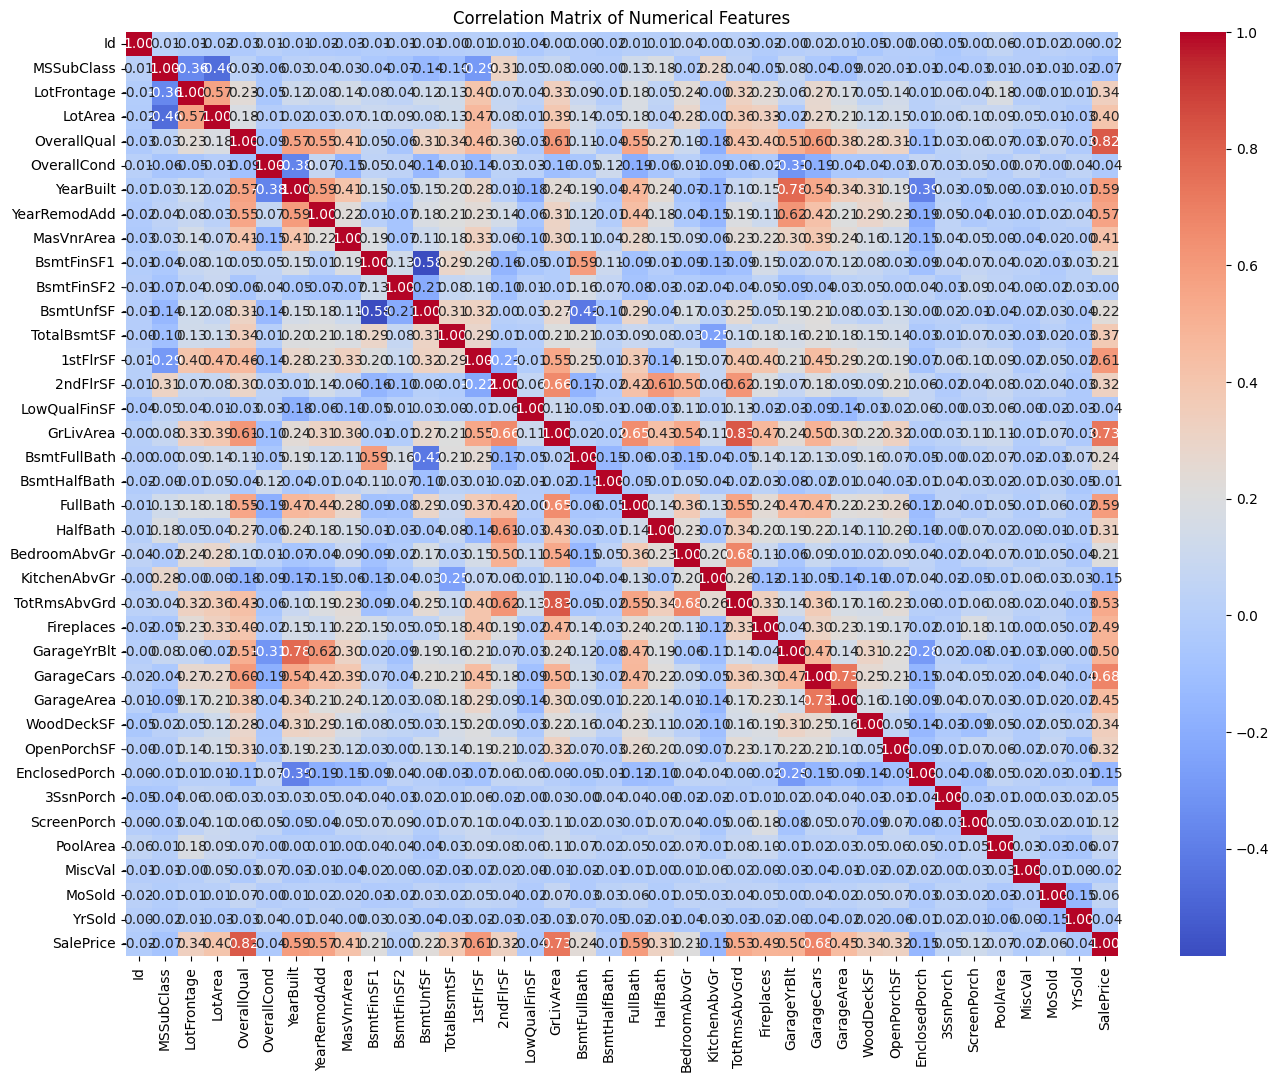

In [7]:
import seaborn as sns

# Select only numeric features
numeric_features = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_features.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()


## Feature Preparation and Encoding

In this step, we separate features and target variable, and encode categorical features using One-Hot Encoding.


In [8]:
# Separate target variable
y = df['SalePrice']
X = df.drop('SalePrice', axis=1)

# One-Hot Encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)


## Train-Test Split

In this step, we split the dataset into training and testing sets to evaluate model performance on unseen data.


In [9]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to check
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1168, 234)
Test shape: (292, 234)


## Linear Regression Model

We start with a simple Linear Regression model as our baseline to predict house prices.


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize and fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test data
y_pred = lr.predict(X_test)

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSLE:", rmsle)


RMSLE: 0.15972244123810386


## Ridge Regression Model

In this step, we apply Ridge Regression with regularization to prevent overfitting and improve model performance.


In [11]:
from sklearn.linear_model import Ridge

# Initialize Ridge model with alpha (regularization strength)
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)

# Predict
y_pred_ridge = ridge.predict(X_test)

# RMSLE
rmsle_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print("RMSLE (Ridge):", rmsle_ridge)


RMSLE (Ridge): 0.1321904618781154


## Lasso Regression Model

In this step, we apply Lasso Regression to perform both regularization and feature selection, potentially reducing the number of irrelevant features.


In [12]:
from sklearn.linear_model import Lasso

# Initialize Lasso model
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

# Predict
y_pred_lasso = lasso.predict(X_test)

# RMSLE
rmsle_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print("RMSLE (Lasso):", rmsle_lasso)


RMSLE (Lasso): 0.13560996069405892


## Conclusion and Model Comparison

- Linear Regression RMSLE: 0.1597
- Ridge Regression RMSLE: 0.1321
- Lasso Regression RMSLE: 0.1356

Among the models, Ridge Regression performed best with the lowest RMSLE score, suggesting that it handled multicollinearity and regularization most effectively on this dataset.
